#### Verifica e instala pacotes

In [ ]:
if(!require('dplyr')) install.packages('dplyr')
#if(!require('tm.plugin.webmining')) install.packages('tm.plugin.webmining')
if(!require('purr')) install.packages('purr')
if(!require('tidytext')) install.packages('tidytext')
if(!require('gutenbergr')) install.packages('gutenbergr')
if(!require('ggplot2')) install.packages('ggplot2')
if(!require('lexiconPT')) install.packages('lexiconPT')

In [22]:
library(dplyr)
#library(tm.plugin.webmining)
library(purrr)
library(tidytext)
library(gutenbergr)
library(ggplot2)
library(lexiconPT)

library(readr)
library(stringr)
library(tidyr)
library(reshape2)
library(syuzhet)

In [ ]:
# dickens <- gutenberg_download(c(98, 1400, 46, 730, 786))
machado <- gutenberg_download(c(55752, 56737, 54829, 55682))

library(gutenbergr)
#gutenberg_metadata
library(stringr)
gutenberg_works(str_detect(language, "pt"))

 #### stop words

In [ ]:
custom_stop_words <- bind_rows(stop_words,
                               tibble(word = tm::stopwords("portuguese"),
                                          lexicon = "custom"))
custom_stop_words.search('')

In [ ]:
tidy_machado <- machado %>%
  unnest_tokens(word, text) %>%
  anti_join(custom_stop_words)

In [ ]:
tidy_machado %>%
  count(word, sort = TRUE)

In [ ]:
data("oplexicon_v3.0")
op30 <- oplexicon_v3.0

glimpse(op30)
typeof(op30)
# op30

colnames(op30) <- c("word", "type", "sentiment", "polarity_revision")

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("-1", "negative", x)
              }))

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("1", "positive", x)
              }))

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("0", "neutral", x)
              }))

glimpse(op30)

In [ ]:
bing_word_counts <- tidy_machado %>%
  inner_join(op30) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()
bing_word_counts

In [ ]:
tidy_dickens %>%
  count(word, sort = TRUE) %>%
  filter(n > 600) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() + ggtitle("The Most Common Words in Charles Dickens' Novels")

In [ ]:
bing_word_counts <- tidy_machado %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()
bing_word_counts

In [ ]:
bing_word_counts %>%
  group_by(sentiment) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(y = "Words Contribute to sentiment",
       x = NULL) +
  coord_flip()

In [ ]:
if(!require('wordcloud')) install.packages('wordcloud')
library(wordcloud)
tidy_machado %>%
  anti_join(stop_words) %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 100))

In [ ]:
# library(reshape2)
tidy_machado %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  acast(word ~ sentiment, value.var = "n", fill = 0) %>%
  comparison.cloud(colors = c("#F8766D", "#00BFC4"),
                   max.words = 100)

In [ ]:
machado_bigrams <- machado %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2)
machado_bigrams

In [ ]:
# library(tidyr)
bigrams_separated <- machado_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
bigram_counts

In [ ]:
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")
bigrams_united

In [ ]:
bigram_tf_idf <- bigrams_united %>%
  count(bigram)
bigram_tf_idf <- bigram_tf_idf %>% filter(n>30)
ggplot(aes(x = reorder(bigram, n), y=n), data=bigram_tf_idf) + geom_bar(stat = 'identity') + ggtitle("The Most Common Bigrams in Dickens' novels") + coord_flip()

In [ ]:
library(igraph)
bigram_graph <- bigram_counts %>%
  filter(n > 20) %>%
  graph_from_data_frame()
bigram_graph

In [ ]:
library(ggraph)
set.seed(2017)
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point(color = "darkslategray4", size = 3) +
  geom_node_text(aes(label = name), vjust = 1.8) + ggtitle("Common Bigrams in Dickens' five Novels")

## Sentiment in “A Marca de uma Lagrima”

In [23]:
raw_tale <- read_lines('a-marca-de-uma-lagrima.txt', skip = 78, n_max = 2873)
tale <- character()
for (i in seq_along(raw_tale)) {
        if (i%%10 == 1) tale[ceiling(i/10)] <- str_c(raw_tale[i], 
                                                     raw_tale[i+1],
                                                     raw_tale[i+2],
                                                     raw_tale[i+3],
                                                     raw_tale[i+4],
                                                     raw_tale[i+5],
                                                     raw_tale[i+6],
                                                     raw_tale[i+7],
                                                     raw_tale[i+8],
                                                     raw_tale[i+9], sep = " ")
}
tale[9:10]

[1] "Levemente, seus dedos tocaram a face fria do inimigo, bem na rachadura. Lentamente, seus dedos percorreram a rachadura, tateando como um cego que procura reconhecer alguém. — Todos riem... Mas eu não queria tantos risos. Eu queria um sorriso apenas. Um só. Queria estar quieta e ver alguém aproximar-se, olhando nos meus olhos... sorrindo... Eu sorriria de volta, e nada mais precisaria ser dito... Isabel deixou as lágrimas correrem fartas pelo rosto. Foi aí que o inimigo resolveu feri-la mais fundo e cortou-lhe o dedo com a borda da rachadura. Num gesto maquinai, a menina levou o dedo à boca, chupando o ferimento. Na rachadura, no peito do inimigo, ficou uma gota de sangue. "
[2] "\fO dedo não doía quase nada. Era ali que doía.  2 - Lindo como um deus Que cheiro bom, Rosana! Que perfume você está usando? — Deixe de besteira, Isabel. É o mesmo que o seu. Rosana estava linda, como sempre. Linda como de propósito para humilhar Isabel. Era mesmo uma beleza a casa da tia Adelaide. O que não parecia uma beleza era a própria tia Adelaide. Recebia os convidados como se ela própria estivesse fazendo dezesseis anos. E o pior é que estava' vestida como se fizesse dezesseis anos."

In [25]:
# library(syuzhet)
tale_nrc <- cbind(linenumber = seq_along(tale), get_nrc_sentiment(tale, language = "portuguese"))

In [26]:
tale_nrc$negative <- -tale_nrc$negative
pos_neg <- tale_nrc %>% select(linenumber, positive, negative) %>% 
        melt(id = "linenumber")
names(pos_neg) <- c("linenumber", "sentiment", "value")

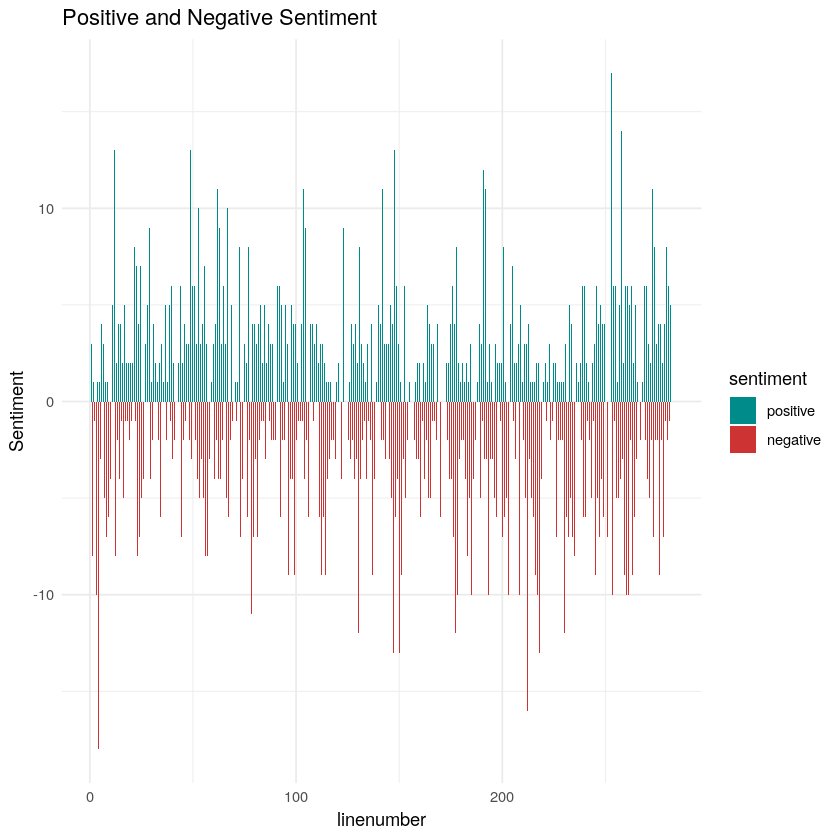

In [27]:
library(ggthemes)
ggplot(data = pos_neg, aes(x = linenumber, y = value, fill = sentiment)) +
        geom_bar(stat = 'identity', position = position_dodge()) + theme_minimal() +
        ylab("Sentiment") + 
        ggtitle("Positive and Negative Sentiment") +
  scale_color_manual(values = c("darkcyan", "brown3")) +
  scale_fill_manual(values = c("darkcyan", "brown3"))

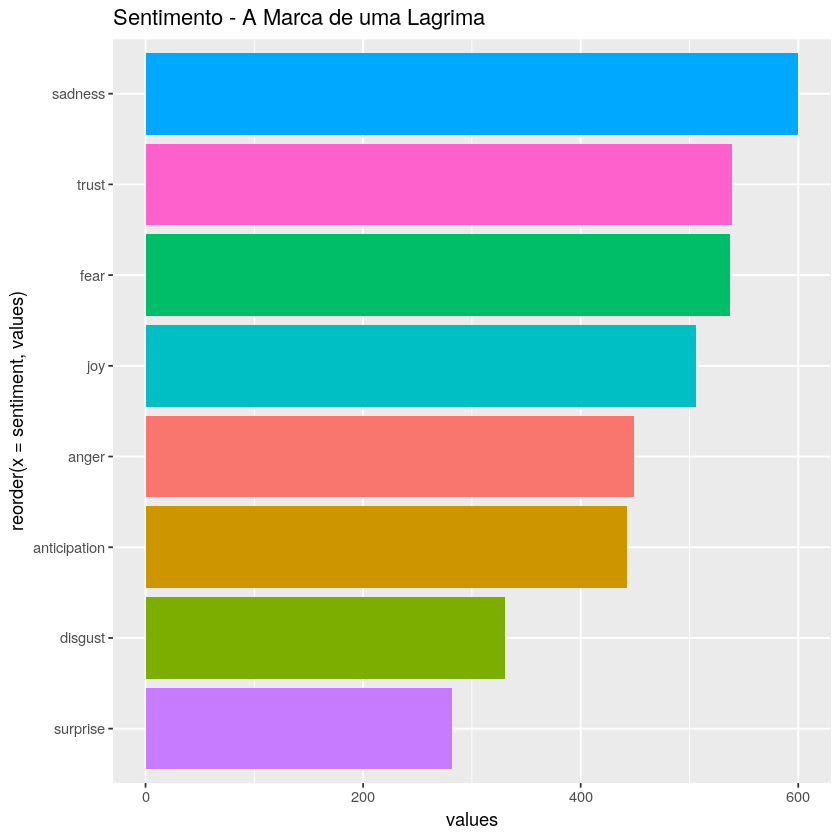

In [28]:
emotions <- tale_nrc %>% select(linenumber, anger, anticipation, 
                                      disgust, fear, joy, sadness, surprise, 
                                      trust) %>% 
        melt(id = "linenumber")
names(emotions) <- c("linenumber", "sentiment", "value")
emotions_group <- group_by(emotions, sentiment)
by_emotions <- summarise(emotions_group, 
                         values=sum(value))
ggplot(aes(reorder(x=sentiment, values), y=values, fill=sentiment), data = by_emotions) +
  geom_bar(stat = 'identity') + ggtitle('Sentimento - A Marca de uma Lagrima') +
  coord_flip() + theme(legend.position="none")